# Analysing Stack Exchange to find popular Data Science topics

**welcomed questions**  
Stack Exchange welcomes questions that don't have a fixed answer.
Some questions sound simple on the surface but very often invite answers from a wide spectrum of topics and disciplines.  
Questions with many upvotes appear to be those that have been well-researched or coprehensively contextualized by the question's author.

**home subdivisions**  
other than a featured list of site-specific questions there is also
- a list of questions from other Stack Exchange sites
- a selection of popular tags
- links to Stack Exchange's own job platform

**Tags** might prove quite useful towards extracting popular topics. Tags offer a means of grouping individual questions that might make a great unit of analysis for us.

**Stack Exchange Database Explorer**
https://data.stackexchange.com/datascience/query  
A few tables that look promising:
- Posts
- PostTags
- Tags
- TagSynonyms

### Preparation

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
sns.set_style('darkgrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [59]:
quests = pd.read_csv('2019_questions.csv', parse_dates=['CreationDate'])
quests.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,44419,2019-01-23 09:21:13,1,21,<machine-learning><data-mining>,0,NaN
1,44420,2019-01-23 09:34:01,0,25,<machine-learning><regression><linear-regressi...,0,NaN
2,44423,2019-01-23 09:58:41,2,1651,<python><time-series><forecast><forecasting>,0,NaN
3,44427,2019-01-23 10:57:09,0,55,<machine-learning><scikit-learn><pca>,1,NaN
4,44428,2019-01-23 11:02:15,0,19,<dataset><bigdata><data><speech-to-text>,0,NaN


In [60]:
quests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    1407 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB


### FavoriteCount

In [61]:
print(quests.FavoriteCount.describe())
print('median: {}'.format(quests.FavoriteCount.median()))

count    1407.000000
mean        1.184790
std         0.982766
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        16.000000
Name: FavoriteCount, dtype: float64
median: 1.0


**FavoriteCount** has null values and these make out 85% of the FavoriteCount column. The maximum value is 16 and the mean as well as the median only 1 which makes it relatively safe to interpret null values as zero.  
After this transformation we will be able to cast the columns datatype to int.

In [62]:
quests.FavoriteCount = quests.FavoriteCount.fillna(0).astype(int)

### Tags

In [63]:
quests.Tags.head()

0                      <machine-learning><data-mining>
1    <machine-learning><regression><linear-regressi...
2         <python><time-series><forecast><forecasting>
3                <machine-learning><scikit-learn><pca>
4             <dataset><bigdata><data><speech-to-text>
Name: Tags, dtype: object

In the current form the **Tags** column is hard to handle.  
Each column value contains a number of tags stringed together.  

Thankfully, tag names are delimited appropriately so that they can be extracted using a simple regular expression. ~~We need to transform our dataset so that each row contains only a single tag name in order to analyze their frequencies.~~ (explode method not supported in this pandas version)

In [64]:
def extract_tags(series):
    return series.str.findall(r'<(.*?)>')

In [65]:
quests.Tags = extract_tags(quests.Tags)

## Counting Tags

In [66]:
def build_tag_freq_map(df, custom_count_fn=lambda x: 1):
    freq_map = {}
    for index, row in df.iterrows():
        for tag in row.Tags:
            prev_count = freq_map.get(tag, 0)
            freq_map[tag] = prev_count + custom_count_fn(row)
    return freq_map

In [67]:
def freq_map_to_df(freq_map):
    df = pd.DataFrame.from_dict(freq_map, orient='index')
    df.columns = ['count']
    return df

In [68]:
used = freq_map_to_df(build_tag_freq_map(quests))
viewed = freq_map_to_df(build_tag_freq_map(quests, lambda row: row.ViewCount))

In [69]:
def create_top_tag_bars(tag_counts, title = ''):
    top_tags = tag_counts.sort_values('count', ascending=False).head(15)
    return top_tags.iloc[::-1].plot(kind='barh', title=title)

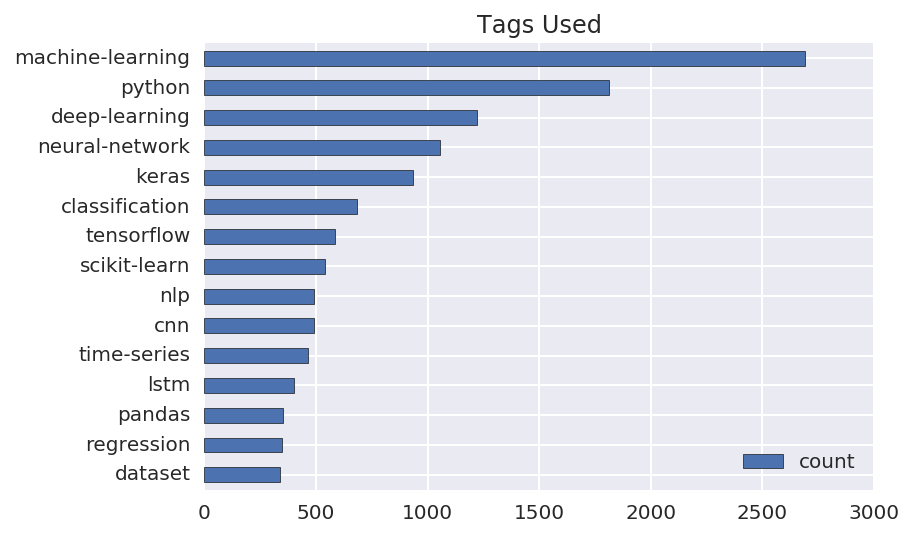

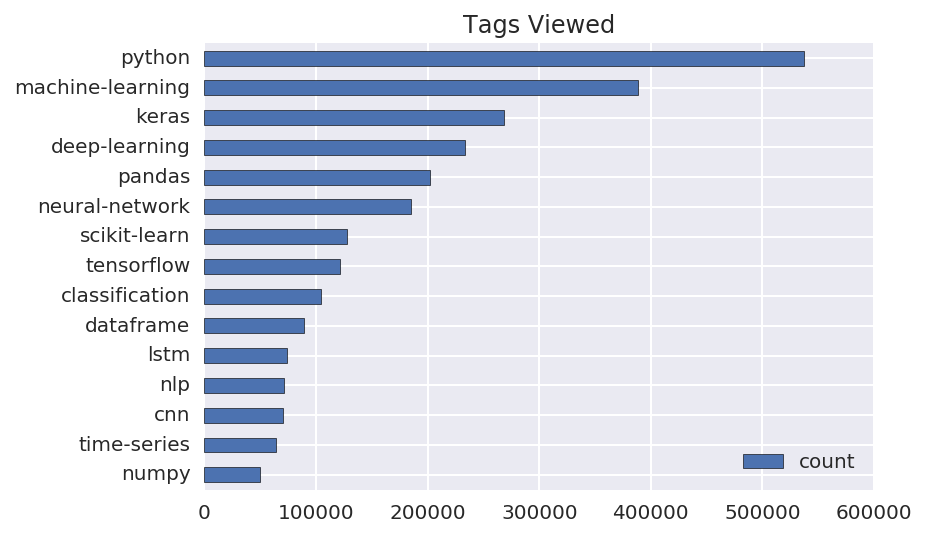

In [70]:
create_top_tag_bars(used, 'Tags Used');
create_top_tag_bars(viewed, 'Tags Viewed');

### Tags Used / Viewed

In [71]:
def diff(df1, df2):
    [set1, set2] = [set(df.index.tolist()) for df in [df1, df2]]
    return list(set1.difference(set2))

In [72]:
top_num = 20

top_used = used.sort_values('count', ascending=False).head(top_num)
top_viewed = viewed.sort_values('count', ascending=False).head(top_num)

print('\nWithin top {} tags\n'.format(top_num))
print('- only used:\n{}'.format('\n'.join(diff(top_used, top_viewed))))
print('\n')
print('- only viewed:\n{}'.format('\n'.join(diff(top_viewed, top_used))))


Within top 20 tags

- only used:
machine-learning-model
statistics
r
predictive-modeling


- only viewed:
numpy
dataframe
csv
pytorch


## Is Deep Learing just a fad?

### Preparation

In [73]:
all_quests = pd.read_csv('all_questions.csv', parse_dates=['CreationDate'])
all_quests.Tags = extract_tags(all_quests.Tags)
all_quests.head()

,Id,CreationDate,Tags
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]"
1,45418,2019-02-12 00:50:39,[neural-network]
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]"
3,45426,2019-02-12 04:51:49,[keras]
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode..."


### Deep Learning Tags

In [74]:
source_tag = 'deep-learning'

tag_qs = all_quests[all_quests.Tags.str.contains(source_tag, regex=False)]
all_count = all_quests.shape[0]
target_count = tag_qs.shape[0]
portion = target_count / all_count

print('\nall questions: {}'.format(all_count))
print('"{}" questions: {} ({:.1%})'.format(source_tag, target_count, portion))

related_tags = freq_map_to_df(build_tag_freq_map(tag_qs))
related_tags.sort_values('count', ascending=False).head(10)


all questions: 21576
"deep-learning" questions: 2805 (13.0%)


,count
deep-learning,2805
machine-learning,1191
neural-network,930
keras,531
tensorflow,381
python,336
cnn,307
lstm,188
convnet,177
classification,159


In [178]:
deep_learning_tags = ["lstm", "cnn", "scikit-learn", "tensorflow",
                   "keras", "neural-network", "deep-learning"]

def discern_dl_q(tag_list):
    return any(tag in deep_learning_tags for tag in tag_list)

all_quests['DeepLearningQ'] = all_quests.Tags.apply(discern_dl_q)
all_quests.DeepLearningQ.value_counts()

False    13758
True      7818
Name: DeepLearningQ, dtype: int64

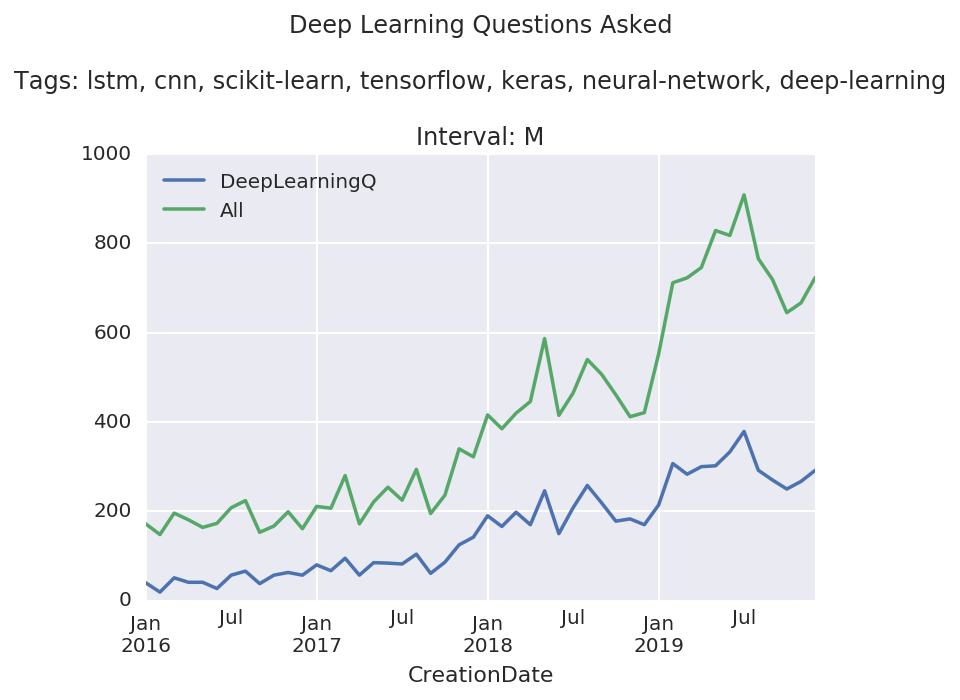

In [184]:
interval = 'M'
all_quests['All'] = True
qs_time = all_quests.groupby(pd.Grouper(key='CreationDate', freq=interval))
dl_qs_time = qs_time.DeepLearningQ.sum()
all_qs_time = qs_time['All'].sum()

upper_limit = dl_qs_time.index < '2020'
lower_limit = dl_qs_time.index >= '2016'
time_frame = lower_limit & upper_limit
highlight = (dl_qs_time.index >= '2019') & upper_limit

main_title = 'Deep Learning Questions Asked'
tags_title = 'Tags: {}'.format(', '.join(deep_learning_tags))
interval_title = 'Interval: {}'.format(interval)
title = '{}\n\n{}\n\n{}'.format(main_title, tags_title, interval_title)

dl_qs_time[time_frame].plot(kind='line', title=title, legend=True)
all_qs_time[time_frame].plot(kind='line', legend=True);

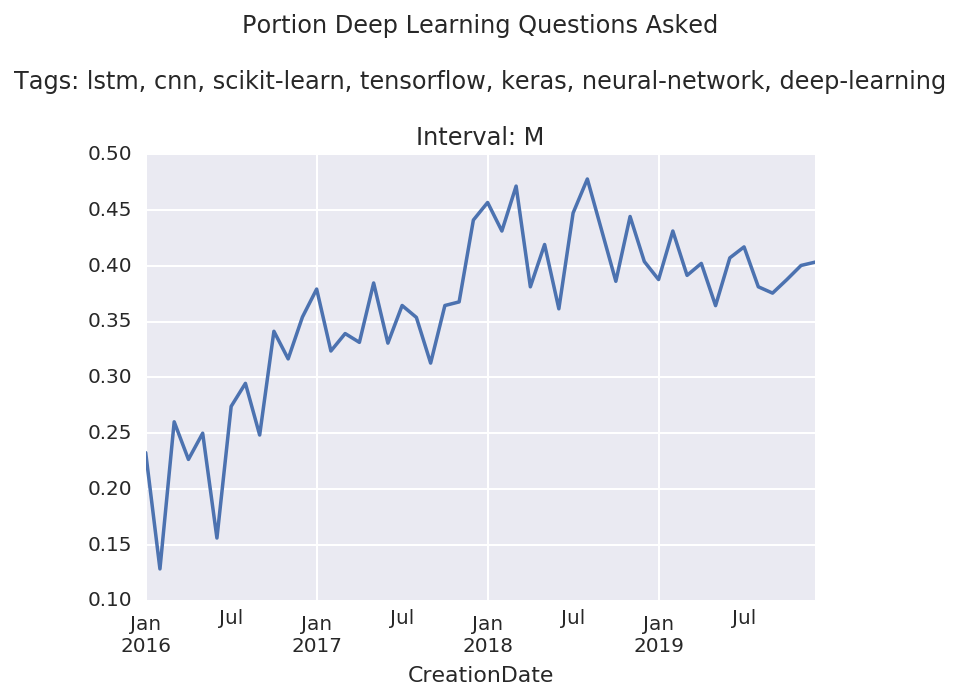

In [185]:
rel_dl_time = dl_qs_time / all_qs_time

portion_title = 'Portion Deep Learning Questions Asked'
title = '{}\n\n{}\n\n{}'.format(portion_title, tags_title, interval_title)

rel_dl_time[time_frame].plot(kind='line', title=title);